#Initial Set-Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, random, torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
data_src = 'solar_data_combined_cleaned.csv'
data_df = pd.read_csv(data_src)

In [3]:
data_df

,datetime,local_datetime,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,...,Ozone,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs
0,2018-01-01 16:30:00,2018-01-01 09:30:00,2018,1,1,16,30,-1.2,1.20,0.021,...,0.347,34.07,72.17,0.91,0.13,830,0.4,254,1.1,0.451
1,2018-01-01 16:40:00,2018-01-01 09:40:00,2018,1,1,16,40,-0.8,1.20,0.021,...,0.347,34.81,71.05,0.91,0.13,829,0.4,257,0.9,0.561
2,2018-01-01 16:50:00,2018-01-01 09:50:00,2018,1,1,16,50,-0.3,1.20,0.021,...,0.346,33.56,69.98,0.91,0.13,829,0.4,259,0.7,0.568
3,2018-01-01 17:00:00,2018-01-01 10:00:00,2018,1,1,17,0,0.1,1.20,0.021,...,0.346,32.60,68.98,0.91,0.13,829,0.4,262,0.5,0.596
4,2018-01-01 17:10:00,2018-01-01 10:10:00,2018,1,1,17,10,0.5,1.20,0.021,...,0.345,31.68,68.04,0.91,0.13,829,0.4,219,0.5,0.607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135551,2023-12-31 22:00:00,2023-12-31 15:00:00,2023,12,31,22,0,3.1,1.15,0.029,...,0.326,57.39,75.10,0.86,0.12,827,0.7,71,0.6,0.822
135552,2023-12-31 22:10:00,2023-12-31 15:10:00,2023,12,31,22,10,2.8,1.15,0.029,...,0.326,58.62,76.39,0.86,0.12,827,0.7,74,0.6,0.824
135553,2023-12-31 22:20:00,2023-12-31 15:20:00,2023,12,31,22,20,2.5,1.15,0.029,...,0.327,59.88,77.74,0.87,0.12,827,0.7,77,0.5,0.781
135554,2023-12-31 22:30:00,2023-12-31 15:30:00,2023,12,31,22,30,2.2,1.15,0.029,...,0.327,61.17,79.12,0.87,0.12,827,0.7,80,0.5,0.735


In [4]:
from copy import deepcopy as dc

data = dc(data_df)
data['local_datetime'] = pd.to_datetime(data_df['local_datetime'], errors='coerce')
data.dropna(subset=['local_datetime'], inplace=True)
data.set_index('local_datetime', inplace = True)
data.drop('datetime', axis = 1, inplace = True)
data['Target'] = data['GHI'].shift(-6)
data.dropna(inplace = True)

In [5]:
data

,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,Asymmetry,Clearsky DHI,...,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs,Target
local_datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,2018,1,1,16,30,-1.2,1.20,0.021,0.62,46,...,34.07,72.17,0.91,0.13,830,0.4,254,1.1,0.451,251.0
2018-01-01 09:40:00,2018,1,1,16,40,-0.8,1.20,0.021,0.62,47,...,34.81,71.05,0.91,0.13,829,0.4,257,0.9,0.561,273.0
2018-01-01 09:50:00,2018,1,1,16,50,-0.3,1.20,0.021,0.62,48,...,33.56,69.98,0.91,0.13,829,0.4,259,0.7,0.568,283.0
2018-01-01 10:00:00,2018,1,1,17,0,0.1,1.20,0.021,0.62,49,...,32.60,68.98,0.91,0.13,829,0.4,262,0.5,0.596,323.0
2018-01-01 10:10:00,2018,1,1,17,10,0.5,1.20,0.021,0.62,50,...,31.68,68.04,0.91,0.13,829,0.4,219,0.5,0.607,326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:00:00,2023,12,31,21,0,4.9,1.16,0.029,0.62,52,...,44.88,68.45,0.86,0.12,827,0.6,43,1.3,0.743,203.0
2023-12-31 14:10:00,2023,12,31,21,10,4.6,1.16,0.029,0.62,51,...,45.82,69.41,0.86,0.12,827,0.6,47,1.2,0.666,183.0
2023-12-31 14:20:00,2023,12,31,21,20,4.3,1.16,0.029,0.62,50,...,46.80,70.43,0.86,0.12,827,0.6,52,1.1,0.795,153.0


In [6]:
# Calculate autocorrelation manually
max_lag = 50  # Number of lags to evaluate
autocorr_values = [data['Target'].autocorr(lag=i) for i in range(1, max_lag + 1)]

# Display results
for lag, corr in enumerate(autocorr_values, 1):
    print(f'Lag {lag}: {corr:.3f}')

Lag 1: 0.963
Lag 2: 0.932
Lag 3: 0.900
Lag 4: 0.865
Lag 5: 0.826
Lag 6: 0.784
Lag 7: 0.739
Lag 8: 0.691
Lag 9: 0.641
Lag 10: 0.588
Lag 11: 0.534
Lag 12: 0.479
Lag 13: 0.422
Lag 14: 0.365
Lag 15: 0.307
Lag 16: 0.249
Lag 17: 0.192
Lag 18: 0.136
Lag 19: 0.081
Lag 20: 0.028
Lag 21: -0.022
Lag 22: -0.071
Lag 23: -0.116
Lag 24: -0.159
Lag 25: -0.198
Lag 26: -0.234
Lag 27: -0.266
Lag 28: -0.293
Lag 29: -0.316
Lag 30: -0.335
Lag 31: -0.350
Lag 32: -0.361
Lag 33: -0.367
Lag 34: -0.368
Lag 35: -0.365
Lag 36: -0.358
Lag 37: -0.347
Lag 38: -0.332
Lag 39: -0.313
Lag 40: -0.291
Lag 41: -0.266
Lag 42: -0.237
Lag 43: -0.206
Lag 44: -0.172
Lag 45: -0.137
Lag 46: -0.099
Lag 47: -0.060
Lag 48: -0.021
Lag 49: 0.019
Lag 50: 0.060


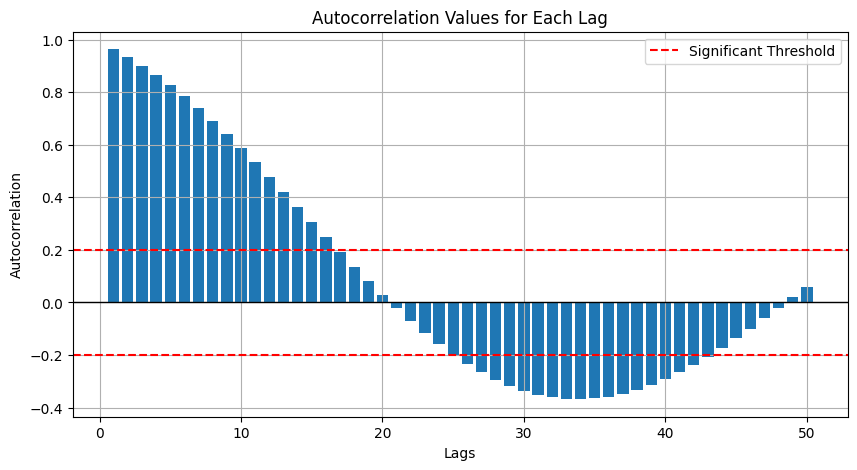

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(range(1, max_lag + 1), autocorr_values)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Threshold')
plt.axhline(y=-0.2, color='red', linestyle='--')
plt.title('Autocorrelation Values for Each Lag')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

#LSTM Setup

In [6]:
import torch

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout, bidirectional = True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
      batch_size = x.size(0)
      h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)
      lstm_out, (h_n, _) = self.lstm(x, (h0, c0))
      return self.fc(lstm_out[:, -1, :])

#Bidirectional LSTM Built

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
      batch_size = x.size(0)
      h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      lstm_out, (h_n, _) = self.lstm(x, (h0, c0))
      return self.fc(lstm_out[:, -1, :])

#Linear LSTM Built

In [9]:
def initialize_model(input_size, neurons, num_layers = 1, learning_rate = 1e-3):
  model = LSTMModel(input_size=input_size, hidden_size=neurons, num_layers=num_layers).to(device)
  criterion = nn.SmoothL1Loss(beta=1.0)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, min_lr = 1e-5, threshold = 0.001)
  return model, criterion, optimizer, scheduler

In [10]:
def train_epoch(model, optimizer, criterion, train_loader):
  model.train(True)
  train_loss = 0

  for batch_idx, (batch_X, batch_Y) in enumerate(train_loader):
      batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

      optimizer.zero_grad()
      outputs = model(batch_X)
      loss = criterion(outputs, batch_Y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() #Use Detach Function

  avg_train_loss = train_loss / len(train_loader)
  return avg_train_loss

In [11]:
def val_epoch(model, criterion, scheduler, val_loader):
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for batch_idx, (batch_X, batch_Y) in enumerate(val_loader):
          batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
          outputs = model(batch_X)
          loss = criterion(outputs, batch_Y)
          val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)
  scheduler.step(avg_val_loss)
  return avg_val_loss

In [12]:
def compute_error(model, X_test_tensor, Y_test_tensor, Y_scaler):
    model.eval()
    with torch.no_grad():
      outputs = model(X_test_tensor).cpu().numpy().flatten()
      outputs = Y_scaler.inverse_transform(outputs.reshape(-1, 1)).flatten()

      actual = Y_test_tensor.cpu().numpy().flatten()
      actual = Y_scaler.inverse_transform(actual.reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(actual, outputs))
    nrmse_mean = rmse / np.mean(actual)
    mae = mean_absolute_error(actual, outputs)
    return rmse, nrmse_mean, mae

In [13]:
class EarlyStopping:
    def __init__(self, patience, optimizer, min_delta = 1e-4):
        self.patience = patience
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.min_delta = min_delta
        self.min_lr = 1e-5
        self.optimizer = optimizer
        self.best_model_state = None

    def check(self, model, avg_val_loss):
        if (self.best_val_loss - avg_val_loss) > self.min_delta:
            self.best_val_loss = avg_val_loss
            self.patience_counter = 0
            self.best_model_state = model.state_dict()  # Save Ideal Model State
        else:
            self.patience_counter += 1
            current_lr = self.optimizer.param_groups[0]['lr']
            if self.patience_counter >= self.patience and current_lr <= self.min_lr:
                print("\n🛑 Early stopping triggered. Restoring best model...")
                model.load_state_dict(self.best_model_state)  # Restore best model
                return True  # Signal to Stop Training
        return False  # Continue Training

In [14]:
def run_model(model, epochs, scheduler, optimizer, criterion, train_loader, val_loader, X_test_tensor, Y_test_tensor, Y_scaler):
  torch.cuda.empty_cache()
  early_stopping = EarlyStopping(patience=10, optimizer = optimizer, min_delta = 1e-5)
  print("Training Model", model)

  lowest_rmse, lowest_nrmse = float('inf'), float('inf')

  for epoch in range(epochs):
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f"\n🔄 Epoch [{epoch+1}/{epochs}] - Training...")

    prev_lr = optimizer.param_groups[0]['lr']

    avg_train_loss = train_epoch(model, optimizer, criterion, train_loader)
    avg_val_loss = val_epoch(model, criterion, scheduler, val_loader)
    rmse, nrmse, mae = compute_error(model, X_test_tensor, Y_test_tensor, Y_scaler)

    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != prev_lr:
        print(f"📉 Learning Rate Reduced at Epoch {epoch + 1}: New LR = {current_lr:.6f}")
        prev_lr = current_lr

    if rmse < lowest_rmse:
      lowest_rmse = rmse
      lowest_nrmse = nrmse

    stop = early_stopping.check(model, avg_val_loss)
    if stop: break

    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
      print(f"📉 Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, RMSE: {rmse:.4f}, nRMSE: {nrmse:.4f}")

  performance = {
        'model_config': model,
        'rmse': lowest_rmse,
        'nrmse': lowest_nrmse,
        'mae': mae
          }
  return performance

#Baseline Model (Entire Feature Set)

In [15]:
def create_3D_sequences(data, timesteps):
    X = []
    Y = []
    data_np = data.drop('Target', axis=1).to_numpy()  # Exclude 'Target' from X
    target_np = data['Target'].to_numpy()             # Isolate 'Target'

    for i in range(len(data_np) - timesteps):
        X.append(data_np[i:i + timesteps])
        Y.append(target_np[i + timesteps])

    return np.array(X), np.array(Y)

In [18]:
timesteps = 30
X, Y = create_3D_sequences(data, timesteps)

In [22]:
def data_split_scale(X, Y):
  train = int(0.8 * len(X))  # 80% Train
  test = len(X) - train #20% test

  X_train, Y_train = X[:train], Y[:train]
  X_test, Y_test = X[train:], Y[train:]

  X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  X_scaler = MinMaxScaler(feature_range=(-1,1))
  Y_scaler = MinMaxScaler(feature_range=(-1,1))

  #Flattening Dataset For Scaling

  X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
  X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

  X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
  X_test_scaled = X_scaler.transform(X_test_reshaped)

  #Reshaping Back Into 3D Dataset

  X_train_scaled = X_train_scaled.reshape(X_train.shape)
  X_test_scaled = X_test_scaled.reshape(X_test.shape)

  Y_train_scaled = Y_scaler.fit_transform(Y_train.reshape(-1,1))
  Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1,1))

  return X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler

X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler = data_split_scale(X, Y)

In [23]:
X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((108416, 30, 12), (27104, 30, 12), (108416, 1), (27104, 1))

In [24]:
class TimeSeriesData(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [25]:
def data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256):
  X_train_tensor = torch.tensor(X_train_scaled, dtype = torch.float32).to(device)
  Y_train_tensor = torch.tensor(Y_train_scaled, dtype = torch.float32).to(device)
  X_test_tensor = torch.tensor(X_test_scaled, dtype = torch.float32).to(device)
  Y_test_tensor = torch.tensor(Y_test_scaled, dtype = torch.float32).to(device)
  train_dataset = TimeSeriesData(X_train_tensor, Y_train_tensor)
  test_dataset = TimeSeriesData(X_test_tensor, Y_test_tensor)
  train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
  test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

  return X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader

In [24]:
from itertools import product
param_grid = {
    'neurons': [32, 64, 128, 256],
    'learning_rate': [1e-3],
    'batch_size': [256],
    'num_layers': [1]
}

'''param_grid = {
    'neurons': [32, 64, 128, 256],
    'learning_rate': [1e-3],
    'batch_size': [32, 64, 128, 256]
}'''

X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader = data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256)

lowest_rmse = float('inf')

for params in product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    print(f"\nEvaluating Configuration: {config}")
    model, criterion, optimizer, scheduler = initialize_model(X_train_tensor.shape[2], config['neurons'], num_layers = config['num_layers'], learning_rate = config['learning_rate'])
    batch_size = config['batch_size']
    epochs = 300

    print(f"Model: {model}, Batch Size: {batch_size}, Total Epochs: {epochs}")

    train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

    performance = run_model(model, epochs, scheduler, optimizer, criterion, train_loader, test_loader, X_test_tensor, Y_test_tensor, Y_scaler)
    print(f"Lowest RMSE: {performance['rmse']:.4f}, nRMSE: {performance['nrmse']:.4f}")

    if performance['rmse'] < lowest_rmse:
        lowest_rmse = performance['rmse']
        lowest_nrmse = performance['nrmse']
        ideal_config = config
        ideal_model = performance['model_config']

print(f"\nBest Configuration: {ideal_config}")


Evaluating Configuration: {'neurons': 32, 'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 1}
Model: LSTMModel(
  (lstm): LSTM(26, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), Batch Size: 256, Total Epochs: 300
Training Model LSTMModel(
  (lstm): LSTM(26, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

🔄 Epoch [10/300] - Training...
📉 Epoch [10/300] - Train Loss: 0.028522, Val Loss: 0.024963, RMSE: 111.6871, nRMSE: 0.2708
📉 Learning Rate Reduced at Epoch 18: New LR = 0.000300

🔄 Epoch [20/300] - Training...
📉 Epoch [20/300] - Train Loss: 0.026870, Val Loss: 0.024816, RMSE: 111.2806, nRMSE: 0.2698

🔄 Epoch [30/300] - Training...
📉 Epoch [30/300] - Train Loss: 0.026294, Val Loss: 0.024315, RMSE: 110.1694, nRMSE: 0.2671

🔄 Epoch [40/300] - Training...
📉 Epoch [40/300] - Train Loss: 0.025998, Val Loss: 0.024209, RMSE: 109.9465, nRMSE: 0.2666
📉 Learning Rate Reduced at Epoch 41: New LR = 0.000090
📉 Learning Ra

#Feature Selection

In [25]:
data

,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,Asymmetry,Clearsky DHI,...,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs,Target
local_datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,2018,1,1,16,30,-1.2,1.20,0.021,0.62,46,...,34.07,72.17,0.91,0.13,830,0.4,254,1.1,0.451,251.0
2018-01-01 09:40:00,2018,1,1,16,40,-0.8,1.20,0.021,0.62,47,...,34.81,71.05,0.91,0.13,829,0.4,257,0.9,0.561,273.0
2018-01-01 09:50:00,2018,1,1,16,50,-0.3,1.20,0.021,0.62,48,...,33.56,69.98,0.91,0.13,829,0.4,259,0.7,0.568,283.0
2018-01-01 10:00:00,2018,1,1,17,0,0.1,1.20,0.021,0.62,49,...,32.60,68.98,0.91,0.13,829,0.4,262,0.5,0.596,323.0
2018-01-01 10:10:00,2018,1,1,17,10,0.5,1.20,0.021,0.62,50,...,31.68,68.04,0.91,0.13,829,0.4,219,0.5,0.607,326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:00:00,2023,12,31,21,0,4.9,1.16,0.029,0.62,52,...,44.88,68.45,0.86,0.12,827,0.6,43,1.3,0.743,203.0
2023-12-31 14:10:00,2023,12,31,21,10,4.6,1.16,0.029,0.62,51,...,45.82,69.41,0.86,0.12,827,0.6,47,1.2,0.666,183.0
2023-12-31 14:20:00,2023,12,31,21,20,4.3,1.16,0.029,0.62,50,...,46.80,70.43,0.86,0.12,827,0.6,52,1.1,0.795,153.0


In [26]:
corr_matrix = data.corr()
target_corr = corr_matrix['Target'].sort_values(ascending = False)
print(target_corr)

Target                1.000000
GHI                   0.783926
Clearsky GHI          0.630786
DNI                   0.527614
Clearsky DNI          0.478773
Kcs                   0.406339
Temperature           0.351200
Clearsky DHI          0.283530
Pressure              0.168755
DHI                   0.108702
Hour                  0.070625
Alpha                 0.062283
Dew Point             0.053119
Wind Speed            0.038541
Precipitable Water    0.023951
Minute                0.001391
Day                  -0.001237
Ozone                -0.005606
Year                 -0.021190
AOD                  -0.022226
Asymmetry            -0.024047
Wind Direction       -0.028513
Month                -0.034564
Surface Albedo       -0.107326
SSA                  -0.122726
Relative Humidity    -0.424248
Solar Zenith Angle   -0.609890
Name: Target, dtype: float64


In [27]:
selected_features = target_corr[abs(target_corr) > 0.3].index.tolist()
print(selected_features)

['Target', 'GHI', 'Clearsky GHI', 'DNI', 'Clearsky DNI', 'Kcs', 'Temperature', 'Relative Humidity', 'Solar Zenith Angle']


In [28]:
trainSet = data.drop('Target', axis = 1, inplace = False)
targetSet = data[['Target']]
X, Y = trainSet.to_numpy(), targetSet.to_numpy()

In [29]:
train = int(0.8 * len(X))  # 80% Train
test = len(X) - train #20% test

X_train, Y_train = X[:train], Y[:train]
X_test, Y_test = X[train:], Y[train:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

X_scaler = MinMaxScaler(feature_range=(-1,1))
Y_scaler = MinMaxScaler(feature_range=(-1,1))

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Y_train_scaled = Y_scaler.fit_transform(Y_train.reshape(-1,1))
Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1,1))

In [30]:
X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((108440, 26), (27110, 26), (108440, 1), (27110, 1))

In [31]:
from sklearn.ensemble import ExtraTreesRegressor

# Train model
etr = ExtraTreesRegressor()
Y_train_scaled = Y_train_scaled.ravel()
etr.fit(X_train_scaled, Y_train_scaled)

# Get feature importance
importances = etr.feature_importances_
trainSet = data.drop('Target', axis = 1, inplace = False)
featuresTrain = trainSet.columns.tolist()

# Sort and plot
feat_imp = pd.Series(importances, index=featuresTrain).sort_values(ascending=False)
print(feat_imp)
top_features = feat_imp[feat_imp > 0.01].index
print(top_features)

GHI                   0.428012
Hour                  0.181761
Clearsky GHI          0.083030
Solar Zenith Angle    0.064149
DNI                   0.055376
Kcs                   0.020752
Wind Direction        0.011792
Relative Humidity     0.011244
DHI                   0.011150
SSA                   0.011137
Clearsky DNI          0.010503
Pressure              0.009595
Precipitable Water    0.008701
Wind Speed            0.008647
Temperature           0.008402
Day                   0.008312
Clearsky DHI          0.007993
Ozone                 0.007967
Year                  0.007819
Alpha                 0.007589
Dew Point             0.007308
Minute                0.006212
AOD                   0.006194
Surface Albedo        0.005862
Month                 0.005271
Asymmetry             0.005220
dtype: float64
Index(['GHI', 'Hour', 'Clearsky GHI', 'Solar Zenith Angle', 'DNI', 'Kcs',
       'Wind Direction', 'Relative Humidity', 'DHI', 'SSA', 'Clearsky DNI'],
      dtype='object')


In [32]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
Y_train_scaled = Y_train_scaled.ravel()
xgb.fit(X_train_scaled, Y_train_scaled)

# Get feature importance
importances = xgb.feature_importances_
trainSet = data.drop('Target', axis = 1, inplace = False)
featuresTrain = trainSet.columns.tolist()

# Sort and plot
feat_imp = pd.Series(importances, index=featuresTrain).sort_values(ascending=False)
print(feat_imp)
top_features = feat_imp[feat_imp > 0.01].index
print(top_features)

GHI                   0.684858
Hour                  0.178251
Clearsky GHI          0.011385
Solar Zenith Angle    0.010711
SSA                   0.010263
Relative Humidity     0.009044
Kcs                   0.007119
Month                 0.006733
Pressure              0.006711
Clearsky DNI          0.006532
Wind Direction        0.006103
Precipitable Water    0.005546
Dew Point             0.005021
Temperature           0.004873
Alpha                 0.004679
Ozone                 0.004659
Surface Albedo        0.004573
Wind Speed            0.004286
Asymmetry             0.004207
AOD                   0.004192
DNI                   0.004113
Day                   0.003997
DHI                   0.003725
Clearsky DHI          0.003572
Year                  0.003307
Minute                0.001540
dtype: float32
Index(['GHI', 'Hour', 'Clearsky GHI', 'Solar Zenith Angle', 'SSA'], dtype='object')


In [33]:
from sklearn.feature_selection import mutual_info_regression

def select_features_by_mutual_info(df, target, threshold=0.01):
    """
    Selects features based on mutual information with the target variable.

    Parameters:
        df (pd.DataFrame): DataFrame containing all features and target.
        target (str): Name of the target column.
        threshold (float): Minimum MI score required to keep a feature.

    Returns:
        selected_features (list): List of selected features.
        mi_scores (pd.Series): Mutual information scores for all features.
    """

    # Compute mutual information scores
    mi_scores = mutual_info_regression(trainSet, targetSet)

    # Convert to a Pandas Series for better visualization
    mi_scores = pd.Series(mi_scores, index=trainSet.columns).sort_values(ascending=False)

    # Select features above the threshold
    selected_features = mi_scores[mi_scores > threshold].index.tolist()

    return selected_features, mi_scores

# Example Usage
selected_features, mi_scores = select_features_by_mutual_info(data, target="target_variable", threshold=0.01)

# Print selected features
print("Selected Features:", selected_features)

# Show MI scores for all features
print(mi_scores)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selected Features: ['GHI', 'Clearsky GHI', 'Solar Zenith Angle', 'Hour', 'DHI', 'DNI', 'Clearsky DHI', 'Clearsky DNI', 'Month', 'Relative Humidity', 'Kcs', 'AOD', 'Temperature', 'Dew Point', 'SSA', 'Alpha', 'Wind Direction', 'Surface Albedo', 'Precipitable Water', 'Ozone', 'Pressure', 'Asymmetry', 'Wind Speed']
GHI                   0.680777
Clearsky GHI          0.619907
Solar Zenith Angle    0.519692
Hour                  0.360906
DHI                   0.277944
DNI                   0.263181
Clearsky DHI          0.230134
Clearsky DNI          0.224782
Month                 0.142116
Relative Humidity     0.118162
Kcs                   0.112278
AOD                   0.098413
Temperature           0.098213
Dew Point             0.061818
SSA                   0.052931
Alpha                 0.051844
Wind Direction        0.049161
Surface Albedo        0.046519
Precipitable Water    0.036573
Ozone                 0.031669
Pressure              0.022579
Asymmetry             0.018744
Wind 

#Testing Ground

In [16]:
data.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Alpha', 'AOD',
       'Asymmetry', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Dew Point', 'DHI', 'DNI', 'GHI', 'Ozone', 'Relative Humidity',
       'Solar Zenith Angle', 'SSA', 'Surface Albedo', 'Pressure',
       'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Kcs', 'Target'],
      dtype='object')

In [60]:
trainSet = data[['Hour', 'Temperature', 'Pressure', 'DHI', 'Clearsky DNI', 'GHI', 'Clearsky GHI', 'DNI', 'Relative Humidity', 'SSA', 'Temperature', 'Solar Zenith Angle', 'Kcs', 'Target']]

In [61]:
trainSet

,Hour,Temperature,Pressure,DHI,Clearsky DNI,GHI,Clearsky GHI,DNI,Relative Humidity,SSA,Temperature,Solar Zenith Angle,Kcs,Target
local_datetime,,,,,,,,,,,,,,
2018-01-01 09:30:00,16,-1.2,830,133,878,142,315,27,34.07,0.91,-1.2,72.17,0.451,251.0
2018-01-01 09:40:00,16,-0.8,829,161,894,189,337,85,34.81,0.91,-0.8,71.05,0.561,273.0
2018-01-01 09:50:00,16,-0.3,829,171,907,204,359,95,33.56,0.91,-0.3,69.98,0.568,283.0
2018-01-01 10:00:00,17,0.1,829,185,919,226,379,115,32.60,0.91,0.1,68.98,0.596,323.0
2018-01-01 10:10:00,17,0.5,829,198,929,241,397,114,31.68,0.91,0.5,68.04,0.607,326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:00:00,21,4.9,827,183,894,283,381,270,44.88,0.86,4.9,68.45,0.743,203.0
2023-12-31 14:10:00,21,4.6,827,170,882,241,362,203,45.82,0.86,4.6,69.41,0.666,183.0
2023-12-31 14:20:00,21,4.3,827,142,869,271,341,385,46.80,0.86,4.3,70.43,0.795,153.0


In [62]:
timesteps = 30
X, Y = create_3D_sequences(trainSet, timesteps)

In [63]:
X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler = data_split_scale(X, Y)

In [64]:
X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((108416, 30, 13), (27104, 30, 13), (108416, 1), (27104, 1))

In [65]:
from itertools import product
param_grid = {
    'neurons': [128],
    'learning_rate': [1e-3],
    'num_layers': [1]
}

X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader = data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256)

lowest_rmse = float('inf')

for params in product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    print(f"\nEvaluating Configuration: {config}")
    model, criterion, optimizer, scheduler = initialize_model(X_train_tensor.shape[2], config['neurons'], num_layers = config['num_layers'], learning_rate = config['learning_rate'])
    batch_size = 256 #config['batch_size']
    epochs = 150 #config['epochs']

    print(f"Model: {model}, Batch Size: {batch_size}, Total Epochs: {epochs}")

    train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

    performance = run_model(model, epochs, scheduler, optimizer, criterion, train_loader, test_loader, X_test_tensor, Y_test_tensor, Y_scaler)
    print(f"Lowest RMSE: {performance['rmse']:.4f}, nRMSE: {performance['nrmse']:.4f}")

    if performance['rmse'] < lowest_rmse:
        lowest_rmse = performance['rmse']
        lowest_nrmse = performance['nrmse']
        ideal_config = config
        ideal_model = performance['model_config']

print(f"\nBest Configuration: {ideal_config}")


Evaluating Configuration: {'neurons': 128, 'learning_rate': 0.001, 'num_layers': 1}
Model: LSTMModel(
  (lstm): LSTM(13, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), Batch Size: 256, Total Epochs: 150
Training Model LSTMModel(
  (lstm): LSTM(13, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

🔄 Epoch [10/150] - Training...
📉 Epoch [10/150] - Train Loss: 0.030696, Val Loss: 0.029924, RMSE: 122.0229, nRMSE: 0.2958

🔄 Epoch [20/150] - Training...
📉 Epoch [20/150] - Train Loss: 0.029166, Val Loss: 0.027501, RMSE: 117.0559, nRMSE: 0.2838

🔄 Epoch [30/150] - Training...
📉 Epoch [30/150] - Train Loss: 0.028376, Val Loss: 0.026863, RMSE: 115.7584, nRMSE: 0.2806

🔄 Epoch [40/150] - Training...
📉 Epoch [40/150] - Train Loss: 0.027871, Val Loss: 0.025927, RMSE: 113.7057, nRMSE: 0.2757

🔄 Epoch [50/150] - Training...
📉 Epoch [50/150] - Train Loss: 0.027625, Val Loss: 0.025450, RMSE: 112.6563, nRMSE: 0.2731
📉 Learning Rat